# Cylinder Fixed OWC

In [1]:
import numpy as np
import capytaine as cpt
from capytaine.bem.problems_and_results import OWCRadiationProblem, _default_parameters
from capytaine.io.meshio import load_from_meshio
import gmsh
import pygmsh
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.special import jv, j1, iv, i1e, k1e, hankel1; hv = hankel1
from numpy.linalg import solve

In [2]:
# frequencies
f1 = 0.005
nfreq = 100
freq = (np.arange(nfreq)+1)*f1
omega = 2*np.pi*freq

In [3]:
geometry = {
    "barrier_depth": 1.5, # m
    "radius": 2.5, # m
    "water_depth": 100,  # m
}

## Analytical

In [4]:
# aero-thermo-dynamics
p_0 = 101325 # Pa, atmospheric pressure
𝜌_0 = 1.25 # kg/m^3, atmospheric air density
k = 1.25 # polytropic exponent

# hydrodynamics
𝜌_w = _default_parameters['rho'] # kg/m^3, seawater density
g = _default_parameters['g'] # m/s^2, gravitational acceleration

In [5]:
def analytical_solve(geometry, frequency, N, Nk):
    a, b, h = geometry["barrier_depth"], geometry["radius"], geometry["water_depth"]
    ω = 2*np.pi*frequency
    k = ω**2/g
    # kn, Eq 31-32 (14-15)
    def __kn(n, k, h, eps=1e-8):
        if n==None: # Eq 32 (15)
            a, b = 0, 2*max(np.sqrt(k/h), k)
            f = lambda x: k-x*np.tanh(x*h)
            _k = brentq(f, a, b)
        elif n==0:
            _k = -1j * __kn(None, k, h)
        else: # Eq 31 (14)
            a = (n-0.5+eps) * np.pi/h
            b = (n+0.5-eps) * np.pi/h
            f = lambda  x: k + x*np.tan(x*h)
            _k = brentq(f, a, b)
        return _k
    _k = __kn(None, k, h)
    _k0 = __kn(0, k, h)
    _kn = np.zeros(Nk)
    for nk in np.arange(Nk):
        _kn[nk] = __kn(nk+1, k, h)
    # Nn, Eq 30 & 33 (13)
    N0 = 0.5*(1 + np.sin(2*h*_k0)/(2*h*_k0))
    kn2h = 2*h*_kn
    Nn = 0.5*(1 + np.sin(kn2h)/kn2h)
    # Kmn, Eq 93 (~72)
    Kmn = np.zeros((N+1, N+1))
    arg1 = _kn * (h-a)
    arg2 = _kn * b
    fac = (1/(Nn*_kn*h*_kn*b))
    for m in range(N+1):
        for n in range(N+1):
            Kmn[m, n] = np.sum(fac * jv(2*m, arg1) * jv(2*n, arg1) / (i1e(arg2) * k1e(arg2)))
    # L1, L2, Eq 94-95 (73-74)
    L1 = np.zeros((N+1, 1))+0j
    L2 = np.zeros((N+1, 1))+0j
    for m in range(N+1):
        L1[m] = 1 if (m==0) else 0 # Eq 95 (74)
        L2[m] = (-1)**m * 1/np.sqrt(N0) * iv(2*m, _k*(h-a)) # Eq 94 (73)
    # a1, a2, Eq 88 (66)
    a1 = solve(Kmn, L1)
    a2 = solve(Kmn, L2)
    # S mat, Eq 89 (67)
    S11 = np.sum(a1*L1)
    S22 = np.sum(a2*L2)
    S12 = np.sum(a1*L2)
    S21 = np.sum(a2*L1)
    # qr, Eq 61 (~49)
    kb = _k*b
    gamma = np.pi * _k * b * _k * h * j1(kb)
    _Del = S11*S22-S12*S21
    _qr_num = 2*np.pi * k**(-1) * b * (gamma * hv(1, kb) * S11 + 2j*_Del)
    _qr_denom = gamma * hv(1,kb) + 2j*S22
    qr = _qr_num / _qr_denom
    qr *= -1j*ω/(𝜌_w*g)
    # qs , Eq 76 (~58)
    _qs_num = 4*np.pi*1j*_k*b*h*j1(kb)*S21
    _qs_denom = _qr_denom
    qs = _qs_num / _qs_denom
    return qr, qs

In [6]:
# numerical truncation
N = 8
Nk = 2500

# analytical frequencies
f1_a = 0.001
nfreq_a = 1000
freq_a = (np.arange(nfreq_a)+1)*f1_a
omega_a = 2*np.pi*freq_a

# calculate coefficients
Yr, He = [], []
for ifreq in freq_a:
    iqr, iqs = analytical_solve(geometry, ifreq, N, Nk)
    Yr.append(iqr)
    He.append(iqs)
Yr, He = np.array(Yr), np.array(He)

analytical = {"B": np.imag(-Yr), "G": np.real(-Yr)}

/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:25: RuntimeWarning: overflow encountered in sin
  N0 = 0.5*(1 + np.sin(2*h*_k0)/(2*h*_k0))
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:25: RuntimeWarning: invalid value encountered in scalar divide
  N0 = 0.5*(1 + np.sin(2*h*_k0)/(2*h*_k0))
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  N0 = 0.5*(1 + np.sin(2*h*_k0)/(2*h*_k0))
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:41: RuntimeWarning: invalid value encountered in scalar divide
  L2[m] = (-1)**m * 1/np.sqrt(N0) * iv(2*m, _k*(h-a)) # Eq 94 (73)
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:56: RuntimeWarning: invalid value encountered in scalar divide
  qr = _qr_num / _qr_denom
/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_16225/3332742396.py:6

## Mesh

In [7]:
name = "cylinder_OWC"
width = 0.1
barrier_depth = geometry['barrier_depth'] # m
radius_outer = geometry['radius'] + width/2 # m
radius_inner = geometry['radius'] - width/2 # m

mesh_size_factor = 0.5
mesh_size_factor_lid = 0.3
freeboard = 1 # m

In [8]:
with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    cyl_outer = geom.add_cylinder([0,0,0], [0,0,-(barrier_depth+freeboard)], radius_outer)
    cyl_inner = geom.add_cylinder([0,0,0], [0,0,-(barrier_depth+freeboard)], radius_inner)
    geom.translate(cyl_inner, [0,0,freeboard])
    geom.translate(cyl_outer, [0,0,freeboard])
    geom.boolean_difference(cyl_outer, cyl_inner)
    mesh = load_from_meshio(geom.generate_mesh())
    mesh = mesh.keep_immersed_part()

In [9]:
with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor_lid)
    internal_surface = geom.add_disk([0,0,0], radius_inner)
    mesh_lid = load_from_meshio(geom.generate_mesh())

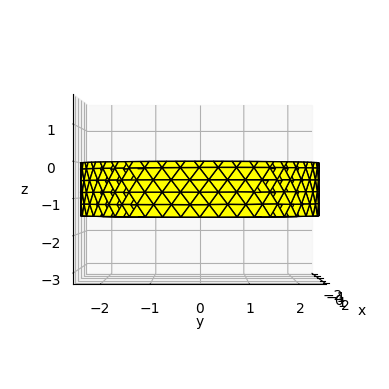

In [10]:
ax = plt.figure().add_subplot(projection="3d")
mesh.show_matplotlib(ax)#(normal_vectors=True, scale_normal_vector=2)
ax.view_init(elev=0, azim=0)

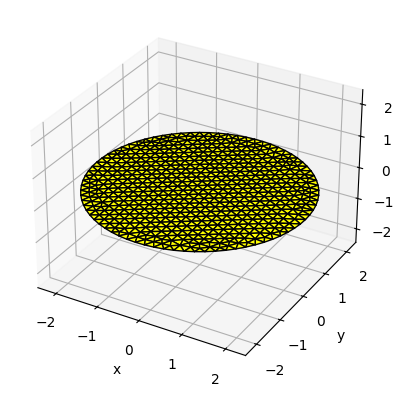

In [11]:
mesh_lid.show_matplotlib()

## BEM

In [12]:
fb = cpt.FloatingBody(name=name, mesh=mesh, lid_mesh=mesh_lid, dofs={},)
solver = cpt.BEMSolver(method="direct")
results = []

print("Solving BEM:")
for i,w in enumerate(omega):
    print(f"  freq: {i+1}/{nfreq}")
    problem = OWCRadiationProblem(body=fb, omega=w)
    results.append(solver.solve_owc(problem, keep_details=True))

[14:10:25] WARNING  Inverting the direction of the normal vectors of Mesh(vertices=[[... 571 vertices ...]],       
                    faces=[[... 1065 faces ...]], name="mesh_from_meshio_6") to be downward.

Solving BEM:
  freq: 1/100
  freq: 2/100
  freq: 3/100
  freq: 4/100
  freq: 5/100
  freq: 6/100
  freq: 7/100
  freq: 8/100
  freq: 9/100
  freq: 10/100
  freq: 11/100
  freq: 12/100
  freq: 13/100
  freq: 14/100
  freq: 15/100
  freq: 16/100
  freq: 17/100
  freq: 18/100
  freq: 19/100
  freq: 20/100
  freq: 21/100
  freq: 22/100
  freq: 23/100
  freq: 24/100
  freq: 25/100
  freq: 26/100
  freq: 27/100
  freq: 28/100
  freq: 29/100
  freq: 30/100
  freq: 31/100
  freq: 32/100
  freq: 33/100
  freq: 34/100
  freq: 35/100
  freq: 36/100
  freq: 37/100
  freq: 38/100
  freq: 39/100
  freq: 40/100
  freq: 41/100
  freq: 42/100
  freq: 43/100
  freq: 44/100
  freq: 45/100
  freq: 46/100
  freq: 47/100
  freq: 48/100
  freq: 49/100
  freq: 50/100
  freq: 51/100
  freq: 52/100
  freq: 53/100
  freq: 54/100
  freq: 55/100
  freq: 56/100
  freq: 57/100
  freq: 58/100
  freq: 59/100
  freq: 60/100
  freq: 61/100
  freq: 62/100
  freq: 63/100
  freq: 64/100
  freq: 65/100
  freq: 66/100
  freq

### Result: Radiation Admittance
The real and imaginary parts of the radiation admittance ($Y_r = G+iB$) are the coefficients needed for the linear OWC model.
The volumetric flow in the chamber due to pressure oscillation is given as $Q_r(\omega) = Y_r(\omega) P(\omega)$.

In [13]:
# integrate vertical. gradients over lid
bem = {
    "G": np.array([result.conductance for result in results]),
    "B": np.array([result.susceptance for result in results]),
}

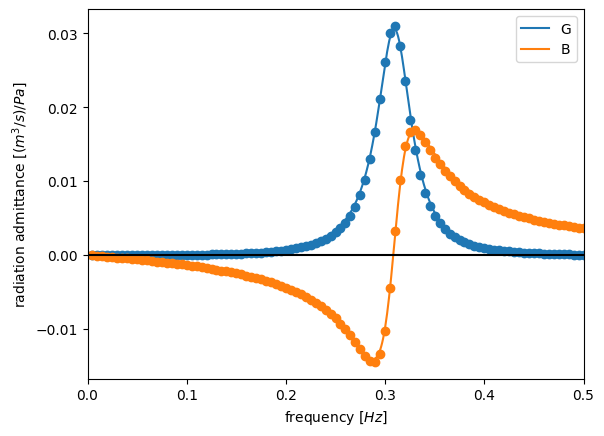

In [15]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(freq_a, analytical["G"], '-', color=default_colors[0], label="G")
plt.plot(freq_a, analytical["B"], '-', color=default_colors[1], label="B")
plt.plot(freq, bem["G"], 'o', color=default_colors[0], label=None)
plt.plot(freq, bem["B"], 'o', color=default_colors[1], label=None)
plt.hlines([0], 0, freq[-1], color="k")
plt.xlim([0, freq[-1]])
plt.xlabel("frequency [$Hz$]")
plt.ylabel("radiation admittance [$(m^3/s)/Pa$]")
plt.legend()